<a href="https://colab.research.google.com/github/seongheechoi/test-1/blob/main/LGE_Question_Answering_%EC%8B%A4%EC%8A%B5%ED%8C%8C%EC%9D%BC_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kobert-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 34.3 MB/s 
     |████████████████████████████████| 1.3 MB 59.0 MB/s 
     |████████████████████████████████| 120 kB 71.7 MB/s 
     |████████████████████████████████| 6.6 MB 35.7 MB/s 


## 디바이스 설정 (CPU or GPU)

In [ ]:
## device 확인
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## cpu 또는 cuda(GPU)
print(device)

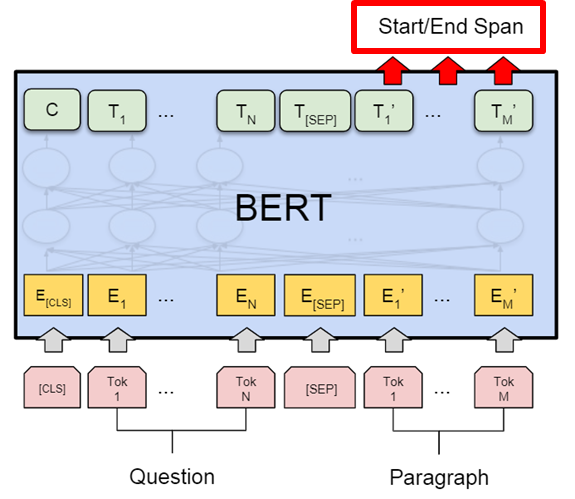

### 모델 로드

In [ ]:

from kobert_transformers import get_tokenizer
from transformers import BertForQuestionAnswering
## https://github.com/huggingface/transformers/blob/v4.21.2/src/transformers/models/bert/modeling_bert.py#L1796

print("--------------------- Model & Tokenizer Load ---------------------\n")
tokenizer = get_tokenizer()
model = BertForQuestionAnswering.from_pretrained('monologg/kobert', num_labels=2)
model.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\n모델 파라미터 수 : {count_parameters(model):,}\n')

print("-------------------- Model & Tokenizer Loaded --------------------")

## Data Download (Korean Question Answering Dataset 1.0
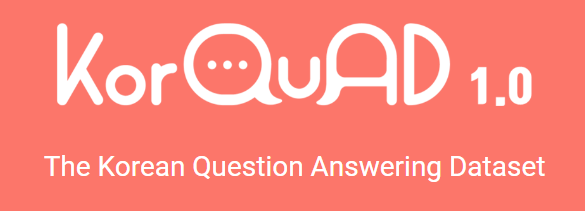

Made by LG CNS D&A Research Center

In [ ]:
## KorQuAD 1.0 Download

!wget https://korquad.github.io/dataset/KorQuAD_v1.0_train.json
!wget https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json

In [ ]:
import json

json_file_name = "KorQuAD_v1.0_dev.json"
with open(json_file_name, 'r', encoding='utf-8') as f:
  json_data = json.load(f)

In [ ]:
## Data Check
json_data['data'][0]['paragraphs'][0]

In [ ]:
valid_data = {"data":json_data['data'][round(len(json_data['data'])/2):]}
test_data = {"data":json_data['data'][:round(len(json_data['data'])/2)]}

In [ ]:
import json

with open("./KorQuAD_v1.0_test.json", "w") as jf:
    json.dump(test_data, jf)

with open("./KorQuAD_v1.0_dev.json", "w") as jf:
    json.dump(valid_data, jf)

In [ ]:
from glob import glob

files = os.path.join("./", 'KorQuAD_v1.0_*.json')
glob_files = sorted(glob(files))
glob_files

In [ ]:
from transformers import logging
logging.set_verbosity_error()

import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset

from glob import glob
from tqdm import tqdm
from torchtext import data

class CustomDataset(Dataset):
  def __init__(self, path='./', split=0, tokenizer=None):
    files = os.path.join(path, 'KorQuAD_v1.0_*.json')
    glob_files = sorted(glob(files))

    if split == 0: ## train
      files = glob_files[2]
    elif split == 1: ## dev
      files = glob_files[0]
    elif split == 2: ## test
      files = glob_files[1]

    print(files)

    with open(files, 'r', encoding='utf-8') as f:
      json_data = json.load(f)

    question_context_input_ids_list = []
    question_context_token_type_ids_list = []
    question_context_attention_mask_list = []
    answer_start_list = []
    answer_end_list = []
    answer_list = []
    context_list = []

    total_num = 0

    data = json_data["data"]
    for i in tqdm(range(len(data))):
      data_paragraphs = data[i]['paragraphs']
      for j in range(len(data_paragraphs)):
        data_paragraphs_qas = data_paragraphs[j]['qas']
        context = data_paragraphs[j]['context']
        for paragraphs_q_n in range(len(data_paragraphs_qas)):
          data_paragraphs_qas_answers = data_paragraphs_qas[paragraphs_q_n]["answers"]
          question = data_paragraphs_qas[paragraphs_q_n]['question']
          for answer_n in range(len(data_paragraphs_qas_answers)):
            tokenized_question_context = tokenizer(question, context, max_length=512, truncation=True)
            answer = data_paragraphs_qas[paragraphs_q_n]['answers'][answer_n]["text"]
            answer_start = data_paragraphs_qas[paragraphs_q_n]['answers'][answer_n]["answer_start"]
            tokenized_answer_start_location = len(tokenizer.encode(question, context[:answer_start])) -1
            tokenized_answer_len = len(tokenizer.encode(answer))-2
            try:
              tokenized_answer_end_location = tokenized_answer_start_location + tokenized_answer_len
            except:
              tokenized_answer_end_location = -1

            if tokenized_answer_end_location != -1:
              question_context_input_ids_list.append(tokenized_question_context['input_ids'])
              question_context_token_type_ids_list.append(tokenized_question_context['token_type_ids'])
              question_context_attention_mask_list.append(tokenized_question_context['attention_mask'])
              answer_start_list.append(tokenized_answer_start_location)
              answer_end_list.append(tokenized_answer_end_location)
              answer_list.append(answer)
              context_list.append(context)

              total_num += 1

    print("전체 처리된 데이터 수: ", total_num)

    self.input_ids = question_context_input_ids_list
    self.token_type_ids = question_context_token_type_ids_list
    self.attention_mask = question_context_attention_mask_list
    self.answer_start = answer_start_list
    self.answer_end = answer_end_list
    self.answer_text = answer_list
    self.context = context_list
    self.pad_idx = 1
  
  def __getitem__(self,index):
    return [self.input_ids[index], self.token_type_ids[index], self.attention_mask[index], self.context[index], self.answer_start[index], self.answer_end[index], self.answer_text[index]]
  
  def __len__(self):
    return len(self.input_ids)

  def custom_collate_fn(self, data):
    input_ids_, token_type_ids_, attention_mask_, context_, answer_start_, answer_end_, answer_text_ = list(zip(*data))
    x_max = max(len(s) for s in input_ids_)

    Question_Context_input_ids_ = [s+[self.pad_idx]*(x_max-len(s)) if len(s) < x_max else s for s in input_ids_]
    Question_Context_token_type_ids_ = [s+[self.pad_idx]*(x_max-len(s)) if len(s) < x_max else s for s in token_type_ids_]
    Question_Context_attention_mask_ = [s+[self.pad_idx]*(x_max-len(s)) if len(s) < x_max else s for s in attention_mask_]
    
    return torch.LongTensor(Question_Context_input_ids_), torch.LongTensor(Question_Context_token_type_ids_), torch.LongTensor(Question_Context_attention_mask_), answer_start_, answer_end_, answer_text_, context_

In [ ]:
import torch.utils.data as torchdata
from torch.utils.data import DataLoader
#from dataloader import CustomDataset

print("====== Data Loader ======")
path = './'
train_loaded = CustomDataset(path=path, split=0, tokenizer=tokenizer)
valid_loaded = CustomDataset(path=path, split=1, tokenizer=tokenizer)
test_loaded = CustomDataset(path=path, split=2, tokenizer=tokenizer)

In [ ]:
print("Train Data 양:", format(len(train_loaded), ','))
print("Valid Data 양:", format(len(valid_loaded), ','))
print("Test Data 양:", format(len(test_loaded), ','))
print("Train + Valid + Test 양:", format(len(train_loaded) + len(valid_loaded) + len(test_loaded), ','))

In [ ]:
print("Question + Context\n")
tokenizer.decode(test_loaded[2][0])

In [ ]:
print("Answer\n")
start_location = test_loaded[0][4]
end_location = test_loaded[0][5]
tokenizer.decode(test_loaded[0][0][start_location:end_location])

In [ ]:
!nvidia-smi

In [ ]:
batch_size = 10


data_loaded = {"Train": train_loaded, "Validation": valid_loaded, "Test": test_loaded}
train_loader = torchdata.DataLoader(dataset=train_loaded,
                                    collate_fn=train_loaded.custom_collate_fn,
                                    batch_size=batch_size,
                                    shuffle=True)
valid_loader = torchdata.DataLoader(dataset=valid_loaded,
                                    collate_fn=valid_loaded.custom_collate_fn,
                                    batch_size=batch_size,
                                    shuffle=True)
test_loader = torchdata.DataLoader(dataset=test_loaded,
                                    collate_fn=test_loaded.custom_collate_fn,
                                    batch_size=batch_size,
                                    shuffle=True)
data_loaders = {"Train": train_loader, "Validation": valid_loader, "Test": test_loader}
print("====== Data Loader Complete ======")

In [ ]:
import time
epochs = 3
lr = 3e-5
print_batch = 10

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=lr)

## if you want using tensorboard loss graph,
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('./')

loss_train = []
train_begin = time.time()
for epoch in range(epochs):
    begin = epoch_begin = time.time()    
    print("-----------------------------------------------------------------------")
    print("[Epoch: ", epoch+1, "]")
    for phase in ['Train', 'Validation',"Test"]:
        train_loss = 0
        valid_loss = 0
        total_num = 0
        valid_total_num = 0
        count = 0
        for batch_no, batch in enumerate(data_loaders[phase]):
            if phase == 'Train':
                model.train(True)
                ## 5개의 입력 중에서. 5개를 다 넣는다는 것은 완벽하게 학습하기 위해서 넣어주는 것.
                # token_type_ids, attention_mask 필수는 아니지만 넣어주는게 맞다.
                output = model(input_ids=batch[0].to(device), token_type_ids = batch[1].to(device), attention_mask = batch[2].to(device), start_positions=torch.LongTensor(batch[3]).to(device), end_positions=torch.LongTensor(batch[4]).to(device))
                loss = output.loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_num += batch[0].size(0)
                train_loss += loss.item()
                
            if phase == 'Validation':
                model.train(False)
                with torch.no_grad():
                    output = model(input_ids=batch[0].to(device), token_type_ids = batch[1].to(device), attention_mask = batch[2].to(device), start_positions=torch.LongTensor(batch[3]).to(device), end_positions=torch.LongTensor(batch[4]).to(device))
                    loss = output[0]
                    valid_total_num += batch[0].size(0)
                    valid_loss += loss.item()

            if phase == 'Test':
                model.train(False)
                with torch.no_grad():
                    output = model(input_ids=batch[0].to(device), token_type_ids = batch[1].to(device), attention_mask = batch[2].to(device), start_positions=torch.LongTensor(batch[3]).to(device), end_positions=torch.LongTensor(batch[4]).to(device))
            
            if batch_no % print_batch == 0:
                current = time.time()
                elapsed = current - begin
                epoch_elapsed = (current - epoch_begin) / 60.0
                train_elapsed = (current - train_begin) / 3600.0
                if phase == "Train":
                    print('{} batch: {:4d}/{:4d}, loss: {:.4f}, elapsed: {:.2f}s {:.2f}m {:.2f}h'
                    .format(phase,
                            batch_no,
                            int(len(data_loaded[phase]) / batch_size) + 1,
                            train_loss / (total_num / batch_size),
                            elapsed, epoch_elapsed, train_elapsed))
                else:
                    print('{} batch: {:4d}/{:4d}, loss: {:.4f}, elapsed: {:.2f}s {:.2f}m {:.2f}h'
                    .format(phase,
                            batch_no,
                            int(len(data_loaded[phase]) / batch_size) + 1,
                            valid_loss / (valid_total_num / batch_size),
                            elapsed, epoch_elapsed, train_elapsed))

                begin = time.time()
                
            if batch_no % 100 == 0 and phase == 'Train':
                with torch.no_grad():
                    output = model(input_ids=batch[0].to(device), token_type_ids = batch[1].to(device), attention_mask = batch[2].to(device))
                    start_location = torch.argmax(output.start_logits, 1 )
                    end_location = torch.argmax(output.end_logits, 1 )
                    for i in range(3):
                        print("===:", i ," batch===")
                        print("Predicted Answer:", tokenizer.decode(batch[0][i][start_location[i]:end_location[i]]))
                        print("Original Answer:", tokenizer.decode(batch[0][i][batch[3][i]:batch[4][i]]))
                        
        
            if batch_no % 50 == 0 and phase == 'Validation':
                with torch.no_grad():
                    model.train(False)
                    output = model(input_ids=batch[0].to(device), token_type_ids = batch[1].to(device), attention_mask = batch[2].to(device))
                    start_location = torch.argmax(output.start_logits, 1 )
                    end_location = torch.argmax(output.end_logits, 1 )
                    for i in range(3):
                        print("===:", i ," batch===")
                        print("Predicted Answer:", tokenizer.decode(batch[0][i][start_location[i]:end_location[i]]))
                        print("Original Answer:", tokenizer.decode(batch[0][i][batch[3][i]:batch[4][i]]))
                        print("=========")

            if batch_no % 50 == 0 and phase == 'Test':
              with torch.no_grad():
                  model.train(False)
                  output = model(input_ids=batch[0].to(device), token_type_ids = batch[1].to(device), attention_mask = batch[2].to(device))
                  start_location = torch.argmax(output.start_logits, 1 )
                  end_location = torch.argmax(output.end_logits, 1 )
                  for i in range(3):
                      print("===:", i ," batch===")
                      print("Predicted Answer:", tokenizer.decode(batch[0][i][start_location[i]:end_location[i]]))
                      print("Original Answer:", tokenizer.decode(batch[0][i][batch[3][i]:batch[4][i]]))
                      print("=========")

        epoch_loss = train_loss / len(data_loaded[phase]) * batch_size
        print("{} Loss: {:.4f}".format(phase, epoch_loss))
        
    
    model.to(torch.device('cpu'))
    torch.save(model.state_dict(), '/content/drive/MyDrive/model_question_answering_save_' + str(epoch) + '.pt')
    model.to(device)
     
    print('--- Model saved ---')


In [ ]:
model.to(torch.device('cpu'))
    torch.save(model.state_dict(), '/content/drive/MyDrive/model_question_answering_save_' + str(epoch) + '.pt')
    model.to(device)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(line)
plt.plot(y_list)
plt.legend(['Train_loss', 'Validation_loss'])
plt.show()

In [ ]:
for batch_no, batch in enumerate(data_loaders['Validation']):
    with torch.no_grad():
        model.train(False)
        output = model(input_ids=batch[0].to(device), token_type_ids = batch[1].to(device), attention_mask = batch[2].to(device))
        start_location = torch.argmax(output.start_logits, 1 )
        end_location = torch.argmax(output.end_logits, 1 )
        for i in range(10):
            print("===:", i ," batch===")
            print("Context:", batch[6][i])
            print("Predicted Answer:", tokenizer.decode(batch[0][i][start_location[i]:end_location[i]]))
            print("Original Answer:", tokenizer.decode(batch[0][i][batch[3][i]:batch[4][i]]))
            print("=========")

    break

## Inference 과정

In [ ]:
## device 확인
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## cpu 또는 cuda(GPU)
print(device)

In [ ]:

from kobert_transformers import get_tokenizer
from transformers import BertForQuestionAnswering
## https://github.com/huggingface/transformers/blob/v4.21.2/src/transformers/models/bert/modeling_bert.py#L1796

print("--------------------- Model & Tokenizer Load ---------------------\n")
tokenizer = get_tokenizer()
model = BertForQuestionAnswering.from_pretrained('monologg/kobert', num_labels=2)
model.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\n모델 파라미터 수 : {count_parameters(model):,}\n')

print("-------------------- Model & Tokenizer Loaded --------------------")

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model_question_answering_save_0.pt'))

In [ ]:
print("질문을 입력하세요.")
question = input()
print("지문을 입력하세요.")
paragraph = input()
tokenized_question_context = tokenizer(question, paragraph, max_length=512, truncation=True, return_tensors='pt')

output = model(input_ids=tokenized_question_context["input_ids"], attention_mask=tokenized_question_context['attention_mask'])

start_location = torch.argmax(output.start_logits, 1 )
end_location = torch.argmax(output.end_logits, 1 )

print("\nPredicted Answer:", tokenizer.decode(tokenized_question_context["input_ids"][start_location[i]:end_location[i]]))
